# Run ECLARE on sample paired data

Import environment variables from YAML file

In [1]:
# Ensure that the environment variables set by the script are accessible in this notebook
import os
import subprocess

# Run the export_env_variables.sh script and capture the output
result = subprocess.run(['bash', '-c', 'config/export_env_variables.sh config/config.yaml'], capture_output=True, text=True)

# Parse the output and set the environment variables in the current Python environment
for line in result.stdout.splitlines()[2:]:
    key, value = line.split('=', 1)
    os.environ[key] = value

# Verify that the environment variables are set
print("ECLARE_ROOT:", os.environ.get("ECLARE_ROOT"))
print("OUTPATH:", os.environ.get("OUTPATH"))
print("DATAPATH:", os.environ.get("DATAPATH"))


ECLARE_ROOT: /home/mcb/users/dmannk/scMultiCLIP/ECLARE
OUTPATH: /home/mcb/users/dmannk/scMultiCLIP/outputs
DATAPATH: /home/mcb/users/dmannk/scMultiCLIP/data


In [2]:
# Go to DATAPATH
os.chdir(os.environ["DATAPATH"])
DATAPATH_TMP = os.environ["DATAPATH"]

Download sample data from Zenodo (only run once)

In [ ]:
'''
# Download the data from the DOI link
!wget https://zenodo.org/records/14799100/files/eclare_sample_zenodo.zip?download=1 -O eclare_data.zip

# Unzip the downloaded data
!unzip eclare_data.zip -d eclare_data
!unzip eclare_data/eclare_sample_zenodo.zip  # takes about 15 minutes @ 5.67 Mb/s
'''

Overwrite the DATAPATH environment variable to the path of the downloaded data


In [3]:
os.environ["DATAPATH"] = os.path.join(DATAPATH_TMP, "eclare_data", "eclare_sample_zenodo")
# generally, os.environ["DATAPATH"] = os.path.join("/path/to/sample/data", "eclare_sample_zenodo")

print("DATAPATH: ", os.environ["DATAPATH"])

DATAPATH:  /home/mcb/users/dmannk/scMultiCLIP/data/eclare_data/eclare_sample_zenodo


### Step 1: train CLIP teacher models

In [4]:
# Got to ECLARE_ROOT
os.chdir(os.environ["ECLARE_ROOT"])

In [ ]:
# Run clip_samples.sh

os.environ['N_EPOCHS'] = '5'

!${ECLARE_ROOT}/scripts/clip_scripts/clip_samples.sh $N_EPOCHS

Job ID: clip_06082406
Source datasets: DLPFC_Anderson DLPFC_Ma
Target datasets: PFC_Zhu
=== Target dataset: PFC_Zhu ===
~~ Align nuclei from DLPFC_Anderson data to PFC_Zhu data. ~~
Genes by peaks string: 7189_by_50937
=== Random state: 17772 ===
/home/mcb/users/dmannk/.conda/envs/eclare_env/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mcb/users/dmannk/.conda/envs/eclare_env/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will 

### Step 2: perform multi-teacher distillation (ECLARE)

In [6]:
# Go to ECLARE_ROOT (in case not already there)
os.chdir(os.environ["ECLARE_ROOT"])

Identify the Job ID related to the CLIP teacher models. Should be shown in the first line output by clip_samples.sh, e.g.:<br>

Job ID: clip_03173230

Can also run code below to identify most common directory in OUTPATH:


In [ ]:
# Get most recent directory in OUTPATH that starts with "clip_"
from glob import glob
clip_dirs = glob(os.path.join(os.environ["OUTPATH"], "clip_*"))
if clip_dirs:
    latest_clip_dir = max(clip_dirs, key=os.path.getmtime)
    clip_job_id = os.path.basename(latest_clip_dir)
    print(f"Most recent CLIP job directory, assigned to clip_job_id: {clip_job_id}")
else:
    print("No CLIP job directories found in OUTPATH")


Most recent CLIP job directory, assigned to clip_job_id: clip_06082406


Run ECLARE

In [9]:
# Run eclare_samples.sh

os.environ['N_EPOCHS'] = '5'
os.environ['CLIP_JOB_ID'] = clip_job_id.split('_')[1]  # only keep digits

!${ECLARE_ROOT}/scripts/eclare_scripts/eclare_samples.sh $N_EPOCHS $CLIP_JOB_ID

Job ID: eclare_06083809
Total epochs: 5
CLIP job ID: 06082406
=== Target dataset: PFC_Zhu ===
=== Random state: 17772 ===
/home/mcb/users/dmannk/.conda/envs/eclare_env/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mcb/users/dmannk/.conda/envs/eclare_env/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-obj

Get most recent ECLARE job ID

In [10]:
# Get most recent directory in OUTPATH that starts with "eclare_"
from glob import glob
eclare_dirs = glob(os.path.join(os.environ["OUTPATH"], "eclare_*"))
if eclare_dirs:
    latest_eclare_dir = max(eclare_dirs, key=os.path.getmtime)
    eclare_job_id = os.path.basename(latest_eclare_dir)

print(f"Most recent ECLARE job directory, assigned to eclare_job_id: {eclare_job_id}")

Most recent ECLARE job directory, assigned to eclare_job_id: eclare_06083809


### Assess model performance

Define functions for importing data and metrics

In [11]:
import pandas as pd
import numpy as np
import os
from glob import glob
import torch
import copy
import matplotlib.pyplot as plt

from eclare import CLIP
from eclare import load_CLIP_model


def get_metrics(method, job_id, target_only=False):

    method_job_id = f'{method}_{job_id}'
    paths_root = os.path.join(os.environ['OUTPATH'], method_job_id)

    ## retain leaf directories only
    paths, all_data_source, all_data_target = [], [], []
    paths = glob(os.path.join(paths_root, '**', '**', '**', f'*_metrics_target_valid.csv'))

    ## For scMulticlip, will not find metrics with previous command
    if paths == []:
        paths = glob(os.path.join(paths_root, '**', '**', f'*_metrics_target_valid.csv'))
    #for dirpath, dirnames, filenames in os.walk(paths_root): paths.append(dirpath) if not dirnames else None

    paths = sorted(paths)

    for path in paths:

        path = os.path.dirname(path)

        ## Get source and target dataset names
        path_split = path.split('/')
        method_job_id_idx = np.where([split==method_job_id for split in path_split])[0][0]

        target = path_split[method_job_id_idx + 1]
        source = path_split[method_job_id_idx + 2] if len(path_split) > method_job_id_idx + 2 else None
        if source in ['0', '1', '2']: source = None

        ## Read metrics
        try:
            metrics_target_valid = pd.read_csv(glob(os.path.join(path, f'*_metrics_target_valid.csv'))[0], index_col=0)
            metrics_source_valid = None if target_only else pd.read_csv(glob(os.path.join(path, f'*_metrics_source_valid.csv'))[0], index_col=0)
        except:
            print(f'Error reading {path}')
            continue

        ## Drop foscttm_score_ct & rank_score
        if 'foscttm_score_ct' in metrics_target_valid.index:
            metrics_target_valid = metrics_target_valid.drop(index=['foscttm_score_ct'])
            if ('foscttm_score_ct' in metrics_source_valid.index) and (not target_only):
                metrics_source_valid = metrics_source_valid.drop(index=['foscttm_score_ct'])

        if 'rank_score' in metrics_target_valid.index:
            metrics_target_valid = metrics_target_valid.drop(index=['rank_score'])
            if ('rank_score' in metrics_source_valid.index) and (not target_only):
                metrics_source_valid = metrics_source_valid.drop(index=['rank_score'])

        ## Transpose, such that metrics as columns rather than indices
        metrics_target_valid = metrics_target_valid.T
        if not target_only:
            metrics_source_valid = metrics_source_valid.T

        ## Add target dataset names, then append to all_data
        metrics_target_valid['target'] = target
        metrics_target_valid['source'] = source
        all_data_target.append(metrics_target_valid)

        if not target_only:
            metrics_source_valid['target'] = target
            metrics_source_valid['source'] = source
            all_data_source.append(metrics_source_valid)

    ## Concatenate all_data and set multi-index
    target_metrics_valid_df = pd.concat(all_data_target).set_index(['source', 'target'])
    target_metrics_valid_df = target_metrics_valid_df.astype(float)

    ## TEMPORARY
    if 'foscttm' in target_metrics_valid_df.columns:
        target_metrics_valid_df = target_metrics_valid_df.rename(columns={'foscttm': 'foscttm_score'})

    if 'ilisi' in target_metrics_valid_df.columns:
        target_metrics_valid_df = target_metrics_valid_df.rename(columns={'ilisi': 'ilisis'})

    if 'clisi' in target_metrics_valid_df.columns:
        target_metrics_valid_df = target_metrics_valid_df.rename(columns={'clisi': 'clisis'})

    ## Replace foscttm_score by 1 - foscttm_score
    if 'foscttm_score' in target_metrics_valid_df.columns:
        target_metrics_valid_df['1 - foscttm_score'] = 1 - target_metrics_valid_df['foscttm_score']
        target_metrics_valid_df = target_metrics_valid_df.drop(columns=['foscttm_score'])

    if target_only:
        return target_metrics_valid_df

    ## --- SOURCE --- ##
    source_metrics_valid_df = pd.concat(all_data_source).set_index(['source', 'target'])
    source_metrics_valid_df = source_metrics_valid_df.astype(float)

    ## TEMPORARY
    if 'foscttm' in source_metrics_valid_df.columns:
        source_metrics_valid_df = source_metrics_valid_df.rename(columns={'foscttm': 'foscttm_score'})

    if 'ilisi' in source_metrics_valid_df.columns:
        source_metrics_valid_df = source_metrics_valid_df.rename(columns={'ilisi': 'ilisis'})

    if 'clisi' in source_metrics_valid_df.columns:
        source_metrics_valid_df = source_metrics_valid_df.rename(columns={'clisi': 'clisis'})

    ## Replace foscttm_score by 1 - foscttm_score
    if 'foscttm_score' in source_metrics_valid_df.columns:
        source_metrics_valid_df['1 - foscttm_score'] = 1 - source_metrics_valid_df['foscttm_score']
        source_metrics_valid_df = source_metrics_valid_df.drop(columns=['foscttm_score'])

    ## Create source-only metrics dataframe, and sort according to existing order of target in original df
    source_only_metrics_valid_df = source_metrics_valid_df.reset_index(level='target').drop(columns='target')
    source_only_metrics_valid_df = source_only_metrics_valid_df.loc[source_metrics_valid_df.index.get_level_values(0).unique().values]

    return source_metrics_valid_df, target_metrics_valid_df, source_only_metrics_valid_df

def compare_dataframes_target(dataframes, value_column, dataset_labels, target_source_combinations, ax=None):

    dataset_label_mapper = {
        'AD_Anderson_et_al': 'DLPFC_Anderson',
        'PD_Adams_et_al': 'Midbrain_Adams',
        'human_dlpfc': 'DLPFC_Ma',
        'roussos': 'PFC_Zhu',
        'mdd': 'MDD'
    }

    hue_order = list(dataset_label_mapper.values())

    combined_df = pd.concat(
        [df.assign(dataset=label).rename(index=dataset_label_mapper)
         for df, label in zip(dataframes, dataset_labels)]
    ).reset_index()

    unique_sources = sorted(combined_df["source"].unique(), key=lambda item: (math.isnan(item), item) if isinstance(item, float) else (False, item))
    unique_targets = sorted(combined_df["target"].unique())

    colors = sns.color_palette("Dark2", 7)
    markers = ['*', 's', '^', 'P', 'D', 'v', '<', '>']

    #target_to_color = {target: colors[i] if len(unique_targets)>1 else 'black' for i, target in enumerate(unique_targets)}
    if len(unique_targets) > 1:
        target_to_color = {hue_order[i]: colors[i] if len(unique_targets)>1 else 'black' for i in range(len(unique_targets))}
    elif unique_targets[0] == 'MDD':
        target_to_color = {unique_targets[0]: colors[6]}

    if target_source_combinations:
        source_to_marker = {source: markers[i % len(markers)] for i, source in enumerate(unique_sources)}
    else:
        source_to_marker = {source: 'o' for i, source in enumerate(unique_sources)}

    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 8))

    sns.boxplot(
        x="dataset",
        y=value_column,
        data=combined_df,
        ax=ax,
        color="lightgray",
        showfliers=False,
        boxprops=dict(alpha=0.4),
        whiskerprops=dict(alpha=0.4),
        capprops=dict(alpha=0.4),
        medianprops=dict(alpha=0.7)
    ).tick_params(axis='x', rotation=30)
    ax.set_xlabel("method")
    ax.yaxis.set_minor_locator(plt.MultipleLocator(0.05))

    # Add scatter points with jitter
    dataset_positions = combined_df["dataset"].unique()
    position_mapping = {dataset: i for i, dataset in enumerate(dataset_positions)}
    for target in unique_targets:
        for dataset in dataset_positions:
            for source in unique_sources:

                if pd.isna(source):
                    subset = combined_df[(combined_df["target"] == target) &
                                        (combined_df["source"].isna()) &
                                        (combined_df["dataset"] == dataset)]
                    x_position = position_mapping[dataset]
                    jitter = np.random.uniform(-0.15, 0.15, size=len(subset))
                    jittered_positions = x_position + jitter
                    ax.scatter(
                        x=jittered_positions,
                        y=subset[value_column],
                        color=target_to_color[target],
                        marker='o',
                        edgecolor=None,
                        s=50,
                        zorder=10,
                        alpha=0.4
                    )

                else:
                    subset = combined_df[(combined_df["source"] == source) &
                                        (combined_df["target"] == target) &
                                        (combined_df["dataset"] == dataset)]
                    x_position = position_mapping[dataset]
                    jitter = np.random.uniform(-0.15, 0.15, size=len(subset))
                    jittered_positions = x_position + jitter
                    ax.scatter(
                        x=jittered_positions,
                        y=subset[value_column],
                        color=target_to_color[target],
                        marker=source_to_marker[source],
                        edgecolor=None,
                        s=50 if source_to_marker[source] == '*' else 50,
                        zorder=10,
                        alpha=0.4
                    )

    return source_to_marker, target_to_color
    
def combined_plot(target_dataframes, value_columns, dataset_labels, target_source_combinations=False, source_only_dataframes=None, figsize=(6,6)):

    # Create a figure with two subplots
    if source_only_dataframes is None:
        fig, axs = plt.subplots(1, len(value_columns), figsize=figsize, sharex=True, squeeze=False)
    else:
        fig, axs = plt.subplots(2, len(value_columns), figsize=figsize, sharey='col')

    for value_column, ax in zip(value_columns, axs[-1]):
        # Pass axes to the individual plotting functions
        source_to_marker, target_to_color = compare_dataframes_target(target_dataframes, value_column, dataset_labels, target_source_combinations, ax=ax)

    # Create handles for color-coding by target
    color_handles = [
        plt.Line2D([0], [0], marker='D' if target_source_combinations else 'o', color=color, label=f"{target}", linestyle='None', markersize=10)
        for target, color in target_to_color.items()
    ]

    # Create handles for marker-coding by source
    marker_handles = [
        plt.Line2D([0], [0], marker=marker, color='black', label=f"{source}", linestyle='None', markersize=10)
        if not pd.isna(source) else
        plt.Line2D([0], [0], marker='o', color='black', label=f"all sources (ensemble)", linestyle='None', markersize=10)
        for source, marker in source_to_marker.items()
    ]


    # Add labels for color and marker sections
    if ( (len(set(source_to_marker.values())) > 1) and ( len(set(target_to_color.keys())) > 1) ):

        # Add a blank entry and title for marker section
        combined_handles = (
            [plt.Line2D([0], [0], color='none', label="Target, by color:")] +
            color_handles +
            [plt.Line2D([0], [0], color='none', label="")] +  # Blank separator
            [plt.Line2D([0], [0], color='none', label="Source, by marker:")] +  # Title for the second block
            marker_handles
        )
        combined_labels = (
            ['Target, by color:'] +
            [f"{target}" for target in target_to_color.keys()] +
            [''] +  # Blank separator
            ["Source, by marker:"] +
            [   f"{source}" if not pd.isna(source) else "all sources (ensemble)"
                for source in source_to_marker.keys()]
        )

    elif ( (len(set(source_to_marker.values())) == 1) and ( len(set(target_to_color.keys())) > 1) ):
        combined_handles = (
            [plt.Line2D([0], [0], color='none', label="Target, by color:")] +
            color_handles
        )
        combined_labels = (
            ['Target, by color:'] +
            [f"{target}" for target in target_to_color.keys()]
        )
    elif ( (len(set(source_to_marker.values())) > 1) and ( len(set(target_to_color.keys())) == 1) ):
        combined_handles = (
            [plt.Line2D([0], [0], color='none', label="Source, by marker:")] +
            marker_handles
        )
        combined_labels = (
            ["Source, by marker:"] +
            [   f"{source}" if not pd.isna(source) else "all sources (ensemble)"
                for source in source_to_marker.keys()]
        )
    else:
        combined_handles = None
        combined_labels = None

    axs[-1,-1].legend(
        handles=combined_handles,
        labels=combined_labels,
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        frameon=False
    )

    # Set a title for the entire figure
    for value_column, ax, letter in zip(value_columns, axs[0], ascii_uppercase):

        ax.set_title(f"{letter}) {value_column}")
        ax.set_xlabel(None)
        ax.set_ylabel(None)

        if source_only_dataframes is not None:
            source_to_target = compare_dataframes_source_only(source_only_dataframes, value_column, dataset_labels, ax=ax)

            axs[0,0].set_ylabel(f"source to source")
            axs[-1,0].set_ylabel(f"source to target")

            combined_handles = (
                [plt.Line2D([0], [0], color='none', label="Source, by color:")] +
                color_handles
            )
            combined_labels = (
                ['Source, by color:'] +
                [f"{target}" for target in target_to_color.keys()]
            )

            axs[0,-1].legend(
                handles=combined_handles,
                labels=combined_labels,
                bbox_to_anchor=(1.05, 1),
                loc='upper left',
                frameon=False
            )

    plt.tight_layout()
    plt.show()

    return fig

def load_clip_and_eclare_model(student_model_path, best_multiclip_idx, device='cpu', genes_by_peaks_str='6816_by_55284'):
    student_model_args_dict = torch.load(student_model_path, map_location=device)

    clip_job_id = student_model_args_dict['args'].clip_job_id
    model_paths = glob(os.path.join(os.environ['OUTPATH'], f'clip_{clip_job_id}/PFC_Zhu/**/{best_multiclip_idx}/model.pt'))

    teacher_models = {}
    for model_path in model_paths:  
        teacher_model, teacher_clip_model_args_dict = load_CLIP_model(model_path, device=device)
        teacher_models[teacher_model.args.source_dataset] = teacher_model.eval()

    # student copies from last teacher model, makes no difference
    student_clip_model_args_dict = copy.deepcopy(teacher_clip_model_args_dict)

    student_clip_model_args_dict['args'].source_dataset = 'PFC_Zhu'
    student_clip_model_args_dict['args'].target_dataset = 'mdd'

    student_clip_model_args_dict['args'].genes_by_peaks_str = genes_by_peaks_str
    student_clip_model_args_dict['n_genes'] = int(genes_by_peaks_str.split('_')[0])
    student_clip_model_args_dict['n_peaks'] = int(genes_by_peaks_str.split('_')[-1])
    student_clip_model_args_dict['tuned_hyperparameters']['params_num_layers'] = 2
    student_clip_model_args_dict['pretrain'] = student_clip_model_args_dict['rna_valid_idx']  = student_clip_model_args_dict['atac_valid_idx'] = None

    student_model = CLIP(**student_clip_model_args_dict, trial=None)
    
    student_model.load_state_dict(student_model_args_dict['model_state_dict'])
    student_model.eval()

    return teacher_models, student_model


/home/mcb/users/dmannk/.conda/envs/eclare_env/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mcb/users/dmannk/.conda/envs/eclare_env/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mcb/users/dmannk/.conda/envs/eclare_env/lib/

In [12]:
# Get metrics
clip_job_id_split = clip_job_id.split('_')[1]
eclare_job_id_split = eclare_job_id.split('_')[1]

source_df_clip, target_df_clip, source_only_df_clip = get_metrics('clip', clip_job_id_split)   # may need to rename 'triplet_align_<job_id>' by 'clip_<job_id>'
target_df_multiclip = get_metrics('eclare', eclare_job_id_split, target_only=True) # may need to rename 'multisource_align_<job_id>' by 'multiclip_<job_id>'


In [13]:
# Load teacher CLIP and student ECLARE models
best_multiclip_idx= str(target_df_multiclip['ilisis'].droplevel(0).argmax())
paths_root = os.path.join(os.environ['OUTPATH'], eclare_job_id)
student_model_path = os.path.join(paths_root, 'PFC_Zhu', best_multiclip_idx, 'student_model.pt')

teacher_models, student_model = load_clip_and_eclare_model(student_model_path, best_multiclip_idx)

model checkpoint
model checkpoint
model checkpoint


In [14]:
# Get nuclei and latents
from eclare.setup_utils import pfc_zhu_setup
from eclare.post_hoc_utils import get_latents

# Teacher data
teacher_rnas, teacher_atacs, teacher_rna_latents_dict, teacher_atac_latents_dict = {}, {}, {}, {}

for source_dataset, teacher_model in teacher_models.items():
    
    teacher_rna, teacher_atac, cell_group, _, _, _, _ = pfc_zhu_setup(teacher_model.args, pretrain=None, return_type='data')
    teacher_rnas[source_dataset] = teacher_rna
    teacher_atacs[source_dataset] = teacher_atac

    teacher_rna_latents, teacher_atac_latents = get_latents(teacher_model, teacher_rna, teacher_atac, return_tensor=True)
    teacher_rna_latents_dict[source_dataset] = teacher_rna_latents
    teacher_atac_latents_dict[source_dataset] = teacher_atac_latents

# Student data
student_rna, student_atac, cell_group, _, _, _, _ = pfc_zhu_setup(student_model.args, pretrain=None, return_type='data')
student_rna_latents, student_atac_latents = get_latents(student_model, student_rna, student_atac, return_tensor=True)

Number of peaks and genes remaining: 50937 peaks & 7189 genes
Number of peaks and genes remaining: 57263 peaks & 6920 genes
Number of peaks and genes remaining: 55284 peaks & 6816 genes


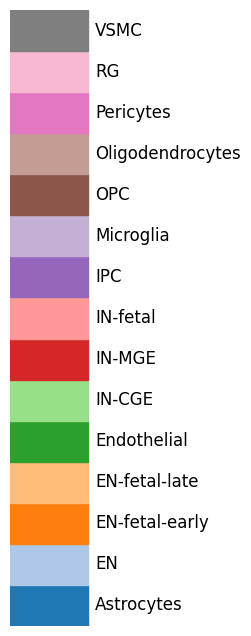

/home/mcb/users/dmannk/.conda/envs/eclare_env/lib/python3.9/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


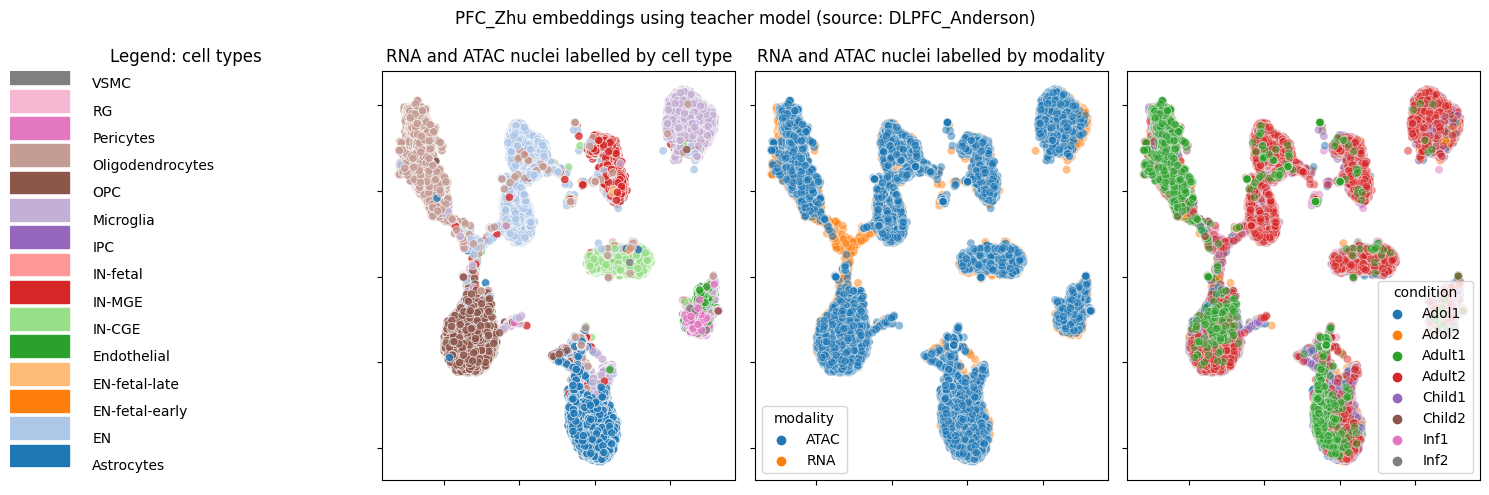

/home/mcb/users/dmannk/.conda/envs/eclare_env/lib/python3.9/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


KeyboardInterrupt: 

In [33]:
# Plot UMAP embeddings for teachers and student
from eclare.post_hoc_utils import plot_umap_embeddings
from eclare.post_hoc_utils import create_celltype_palette

color_map_ct = create_celltype_palette(teacher_rna.obs[cell_group].values, teacher_atac.obs[cell_group].values)

# teachers
for source_dataset in teacher_rnas.keys():
    plot_umap_embeddings(teacher_rna_latents_dict[source_dataset], teacher_atac_latents_dict[source_dataset], teacher_rnas[source_dataset].obs[cell_group].values, teacher_atacs[source_dataset].obs[cell_group].values, None, None, color_map_ct)
    plt.suptitle(f"PFC_Zhu embeddings using teacher model (source: {source_dataset})"); plt.tight_layout(); plt.show()

# student
plot_umap_embeddings(student_rna_latents, student_atac_latents, student_rna.obs[cell_group].values, student_atac.obs[cell_group].values, None, None, color_map_ct)
plt.suptitle(f"PFC_Zhu embeddings using student model"); plt.tight_layout(); plt.show()